# NHANES Diabetes Prediction Model
- 1 in 5 people don't know they have diabetes. 
- Diabetes is the #8 leading cause of death in the United States. 
- People with diabetes pay 2x higher medical bills  

Creating accurate predictive models to help individuals quickly identify diabetes could be pivotal in their lives, and help get them medical attention. 

## Read in Libraries

In [1]:
# load in necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from keras import regularizers


2024-04-30 16:35:57.670348: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 16:35:57.728262: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 16:35:58.222456: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 16:35:58.227018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 16:35:59.317873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Read in the Data
Note: Data pre-processed in R and saved to csv to use for further analysis here.

# Original model with cleaned data

In [2]:
cleaned_data = pd.read_csv('nhanes_cleaned.csv')
cleaned_data.head()

,Unnamed: 0,blood_cholesterol_mg_per_dc,blood_glycosylated_hemoglobin_volume_percentage,family_income,household_adults_60_years_plus,household_children_6_17_years,household_income,household_ref_person_age_year,household_ref_person_biological_sex,household_ref_person_education,...,subject_education,subject_high_blood_pressure,subject_2_year_weight_screening_time,subject_2_year_mec_weight_mec_time,subject_insurance,subject_masked_variance_pseudo_psu,subject_masked_variance_pseudo_stratum,subject_prescription_coverage,subject_race_ethnicity,diagnosis
0,4331,168,5.5,"$65,000 to $74,999",1,0,"$65,000 to $74,999",61,2,College graduate or above,...,College graduate or above,Yes,60325.09525,61758.65488,Covered by state-sponsored health plan,1,114,Yes,White Hispanic,False
1,4332,168,5.2,"$100,000 and Over",0,0,"$100,000 and Over",26,2,College graduate or above,...,College graduate or above,No,89514.43322,91523.51605,Covered by private insurance,2,113,Yes,White Hispanic,False
2,4333,131,5.0,"$45,000 to $54,999",0,1,"$45,000 to $54,999",33,2,College graduate or above,...,College graduate or above,No,14155.31300,15397.21985,Covered by private insurance,2,114,Yes,Non-White,False
3,4334,154,5.1,"$45,000 to $54,999",0,2,"$45,000 to $54,999",35,2,Some college or AA degree,...,9th grade,No,12433.74874,12665.77009,Covered by private insurance,1,104,Yes,White Hispanic,False
4,4336,225,5.8,"$20,000 and Over",0,3,"$20,000 and Over",38,2,High school graduate/GED or equivalent,...,High school graduate/GED or equivalent,No,27388.92069,27196.63839,Covered by private insurance,2,116,Yes,White Hispanic,False


## Further Data Pre-processing

In [3]:
# Define numerical and categorical features
numerical_cols = cleaned_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = cleaned_data.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## Create Model
This will serve as our mose basic model, with no weights, regularization, or extra data

In [61]:
# Create a new model using TensorFlow/Keras, more similar to your class example
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[input_shape]),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Split Data and Fit

In [62]:
# Split data into X and y
X = cleaned_data.drop('diagnosis', axis=1)
y = cleaned_data['diagnosis'].astype(int)  # for binary classification

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the preprocessor to the training data and transform it
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Further split the training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_transformed, y_train, test_size=0.2, random_state=42)

# Get the number of features from the transformed data
input_shape = X_train_transformed.shape[1]

## Build and Fit Model

In [63]:
# Build the model
model = build_model(input_shape)

# Fit the model
model_fit = model.fit(X_train_final, y_train_final, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
68/68 [==============================] - 1s 5ms/step - loss: 0.2940 - accuracy: 0.8966 - val_loss: 0.2125 - val_accuracy: 0.9228
Epoch 2/10
68/68 [==============================] - 0s 3ms/step - loss: 0.1840 - accuracy: 0.9338 - val_loss: 0.1847 - val_accuracy: 0.9375
Epoch 3/10
68/68 [==============================] - 0s 2ms/step - loss: 0.1563 - accuracy: 0.9476 - val_loss: 0.1864 - val_accuracy: 0.9430
Epoch 4/10
68/68 [==============================] - 0s 2ms/step - loss: 0.1395 - accuracy: 0.9527 - val_loss: 0.1818 - val_accuracy: 0.9430
Epoch 5/10
68/68 [==============================] - 0s 2ms/step - loss: 0.1173 - accuracy: 0.9591 - val_loss: 0.1911 - val_accuracy: 0.9393
Epoch 6/10
68/68 [==============================] - 0s 2ms/step - loss: 0.1187 - accuracy: 0.9586 - val_loss: 0.1984 - val_accuracy: 0.9412
Epoch 7/10
68/68 [==============================] - 0s 3ms/step - loss: 0.1032 - accuracy: 0.9637 - val_loss: 0.2051 - val_accuracy: 0.9228
Epoch 8/10
68/68 [==

## Evaluation of Model

In [64]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               11136     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 128)              

In [65]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_transformed, y_test)
print("Accuracy:", accuracy)

22/22 [==============================] - 0s 2ms/step - loss: 0.2561 - accuracy: 0.9369
Accuracy: 0.9368575811386108


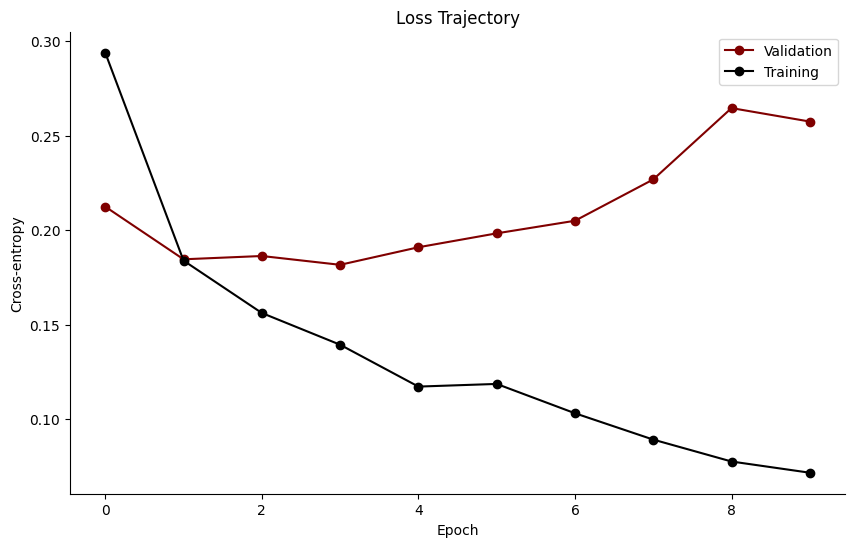

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(10), model_fit.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(10), model_fit.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

22/22 [==============================] - 0s 1ms/step


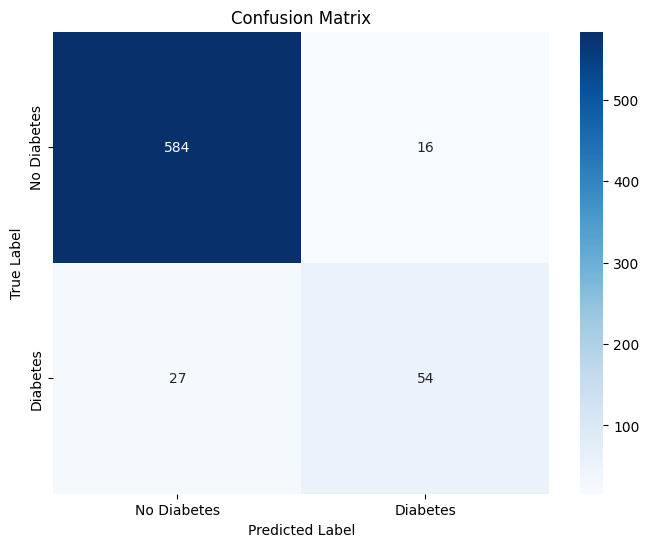

              precision    recall  f1-score   support

 No Diabetes       0.96      0.97      0.96       600
    Diabetes       0.77      0.67      0.72        81

    accuracy                           0.94       681
   macro avg       0.86      0.82      0.84       681
weighted avg       0.93      0.94      0.93       681



In [67]:
# Predict classes using the test set
y_pred = model.predict(X_test_transformed)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report for precision, recall, f1-score
print(classification_report(y_test, y_pred_classes, target_names=['No Diabetes', 'Diabetes']))

## Class Weights
This model now adds bias regulatrizers as well as weights for the two outcomes. The goal of this is to make sure that the accuracy for Diabetes=True is greater

In [68]:
# Create a new model using TensorFlow/Keras, more similar to your class example
def build_regularized_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[input_shape], bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(64, activation='relu', bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(32, activation='relu', bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid', bias_regularizer=regularizers.L2(1e-4))
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [70]:
# Fit the model
weight_for_0 = (1 / 600) * (681 / 2.0)
weight_for_1 = (1 / 81) * (681 / 2.0)

weighted_model = build_regularized_model(input_shape)
class_weight = {0: weight_for_0, 1: weight_for_1}
weighted_model_fit = weighted_model.fit(X_train_final, y_train_final, epochs=20, validation_data=(X_val, y_val), class_weight=class_weight)

Epoch 1/20
68/68 [==============================] - 1s 5ms/step - loss: 0.6108 - accuracy: 0.6866 - val_loss: 0.4305 - val_accuracy: 0.8676
Epoch 2/20
68/68 [==============================] - 0s 3ms/step - loss: 0.4739 - accuracy: 0.8203 - val_loss: 0.3294 - val_accuracy: 0.8805
Epoch 3/20
68/68 [==============================] - 0s 4ms/step - loss: 0.3985 - accuracy: 0.8566 - val_loss: 0.3072 - val_accuracy: 0.8971
Epoch 4/20
68/68 [==============================] - 0s 3ms/step - loss: 0.3661 - accuracy: 0.8635 - val_loss: 0.2391 - val_accuracy: 0.9265
Epoch 5/20
68/68 [==============================] - 0s 2ms/step - loss: 0.3749 - accuracy: 0.8745 - val_loss: 0.2567 - val_accuracy: 0.9173
Epoch 6/20
68/68 [==============================] - 0s 2ms/step - loss: 0.3226 - accuracy: 0.8874 - val_loss: 0.2319 - val_accuracy: 0.9228
Epoch 7/20
68/68 [==============================] - 0s 2ms/step - loss: 0.3070 - accuracy: 0.9026 - val_loss: 0.2406 - val_accuracy: 0.9210
Epoch 8/20
68/68 [==

In [71]:
# Evaluate the model on the test data
loss, accuracy = weighted_model.evaluate(X_test_transformed, y_test)
print("Accuracy:", accuracy)

22/22 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.9192
Accuracy: 0.919236421585083


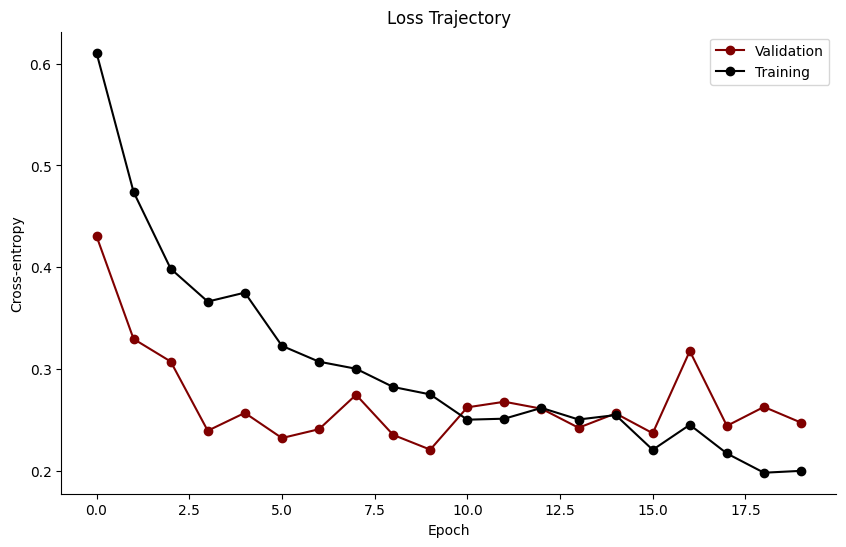

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(20), weighted_model_fit.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(20), weighted_model_fit.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

22/22 [==============================] - 0s 2ms/step


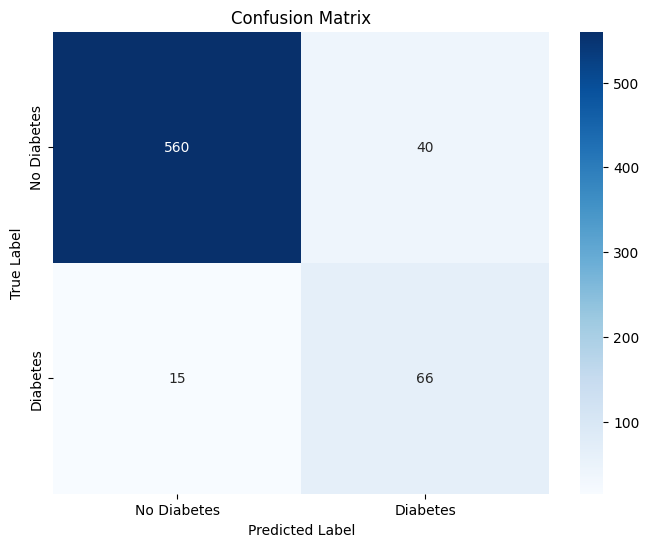

              precision    recall  f1-score   support

 No Diabetes       0.97      0.93      0.95       600
    Diabetes       0.62      0.81      0.71        81

    accuracy                           0.92       681
   macro avg       0.80      0.87      0.83       681
weighted avg       0.93      0.92      0.92       681



In [73]:
# Predict classes using the test set
y_pred = weighted_model.predict(X_test_transformed)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report for precision, recall, f1-score
print(classification_report(y_test, y_pred_classes, target_names=['No Diabetes', 'Diabetes']))

## Smote
This model is similar in design to the first, with no regularization or weights. The difference is in the data. SMOTE (Synthetic Minority Oversampling TEchnique) is used to synthesize new examples for the minority (Diabetes=True) in order to more balance the data. 

In [4]:
# Split data into X and y
X = cleaned_data.drop('diagnosis', axis=1)
y = cleaned_data['diagnosis'].astype(int)

# Split original data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Bundle preprocessing for numerical and categorical data into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the preprocessor to the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE only to the preprocessed training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Split the resampled training data into final training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Get the number of features from the transformed data
input_shape = X_train_resampled.shape[1]

# Check the class distribution after applying SMOTE
print("Before SMOTE:")
print(y_train.value_counts())

print("After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Before SMOTE:
diagnosis
0    2400
1     320
Name: count, dtype: int64
After SMOTE:
diagnosis
0    2400
1    2400
Name: count, dtype: int64


/home/carrc4/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
# Create a new model using TensorFlow/Keras, more similar to your class example
def build_smote_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[input_shape]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# Build the model
smote_model = build_smote_model(input_shape)

# Fit the model
smote_model_fit = smote_model.fit(X_train_resampled, y_train_resampled, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
150/150 [==============================] - 1s 3ms/step - loss: 0.5614 - accuracy: 0.6858 - val_loss: 0.2810 - val_accuracy: 0.8875
Epoch 2/15
150/150 [==============================] - 0s 2ms/step - loss: 0.3451 - accuracy: 0.8637 - val_loss: 0.2346 - val_accuracy: 0.9031
Epoch 3/15
150/150 [==============================] - 0s 2ms/step - loss: 0.2921 - accuracy: 0.8919 - val_loss: 0.1993 - val_accuracy: 0.9312
Epoch 4/15
150/150 [==============================] - 0s 2ms/step - loss: 0.2658 - accuracy: 0.9038 - val_loss: 0.1806 - val_accuracy: 0.9375
Epoch 5/15
150/150 [==============================] - 0s 2ms/step - loss: 0.2258 - accuracy: 0.9254 - val_loss: 0.1543 - val_accuracy: 0.9417
Epoch 6/15
150/150 [==============================] - 0s 2ms/step - loss: 0.2154 - accuracy: 0.9283 - val_loss: 0.1369 - val_accuracy: 0.9521
Epoch 7/15
150/150 [==============================] - 0s 2ms/step - loss: 0.1904 - accuracy: 0.9331 - val_loss: 0.1191 - val_accuracy: 0.9604
Epoch 

In [23]:
# Evaluate the model on the test data
loss, accuracy = smote_model.evaluate(X_test_transformed, y_test)
print("Accuracy:", accuracy)

22/22 [==============================] - 0s 1ms/step - loss: 0.3031 - accuracy: 0.9222
Accuracy: 0.922173261642456


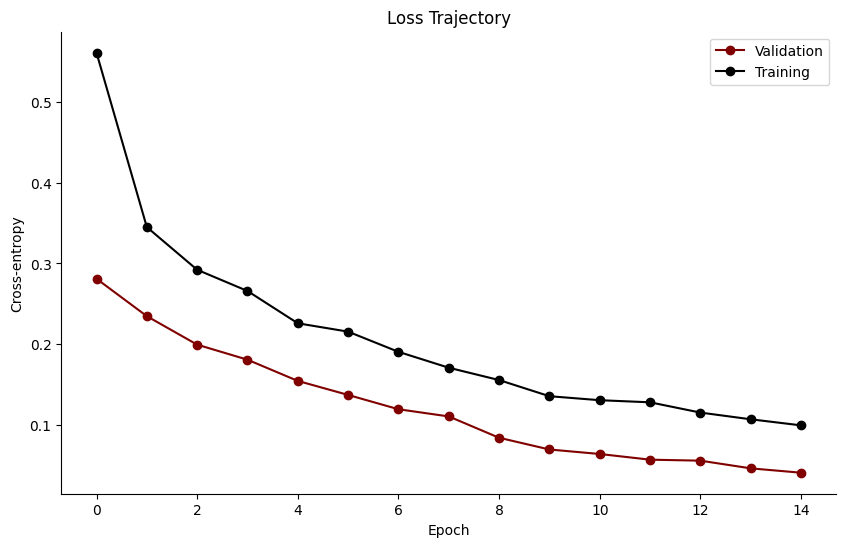

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(15), smote_model_fit.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(15), smote_model_fit.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

22/22 [==============================] - 0s 1ms/step


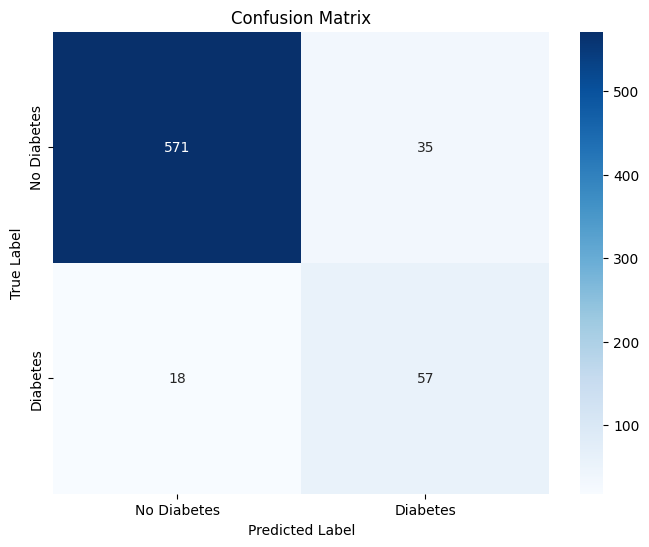

              precision    recall  f1-score   support

 No Diabetes       0.97      0.94      0.96       606
    Diabetes       0.62      0.76      0.68        75

    accuracy                           0.92       681
   macro avg       0.79      0.85      0.82       681
weighted avg       0.93      0.92      0.93       681



In [25]:
# Predict classes using the test set
y_pred = smote_model.predict(X_test_transformed)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report for precision, recall, f1-score
print(classification_report(y_test, y_pred_classes, target_names=['No Diabetes', 'Diabetes']))

## Regularized Smote Model
Adds regularizers and weights to the SMOTE model

In [88]:
# Create a new model using TensorFlow/Keras, more similar to your class example
def build_regularized_smote_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[input_shape], bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu', bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(32, activation='relu', bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid', bias_regularizer=regularizers.L2(1e-4))
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [89]:
# Fit the model
weight_for_0 = (1 / 600) * (681 / 2.0)
weight_for_1 = (1 / 81) * (681 / 2.0)

regularized_smote_model = build_regularized_smote_model(input_shape)
class_weight = {0: weight_for_0, 1: weight_for_1}
weighted_smote_model_fit = regularized_smote_model.fit(X_train_final, y_train_final, epochs=25, validation_data=(X_val, y_val), class_weight=class_weight)

Epoch 1/25
120/120 [==============================] - 1s 4ms/step - loss: 0.7062 - accuracy: 0.5568 - val_loss: 0.5346 - val_accuracy: 0.7635
Epoch 2/25
120/120 [==============================] - 0s 2ms/step - loss: 0.4890 - accuracy: 0.7435 - val_loss: 0.4060 - val_accuracy: 0.8344
Epoch 3/25
120/120 [==============================] - 0s 2ms/step - loss: 0.4050 - accuracy: 0.8214 - val_loss: 0.3428 - val_accuracy: 0.8719
Epoch 4/25
120/120 [==============================] - 0s 2ms/step - loss: 0.3599 - accuracy: 0.8500 - val_loss: 0.3199 - val_accuracy: 0.8750
Epoch 5/25
120/120 [==============================] - 0s 3ms/step - loss: 0.3314 - accuracy: 0.8617 - val_loss: 0.2644 - val_accuracy: 0.8990
Epoch 6/25
120/120 [==============================] - 0s 2ms/step - loss: 0.2964 - accuracy: 0.8776 - val_loss: 0.2309 - val_accuracy: 0.9115
Epoch 7/25
120/120 [==============================] - 0s 2ms/step - loss: 0.2606 - accuracy: 0.8982 - val_loss: 0.2243 - val_accuracy: 0.9177
Epoch 

In [90]:
# Evaluate the model on the test data
loss, accuracy = regularized_smote_model.evaluate(X_test_transformed, y_test)
print("Accuracy:", accuracy)

22/22 [==============================] - 0s 1ms/step - loss: 0.3892 - accuracy: 0.9119
Accuracy: 0.9118942618370056


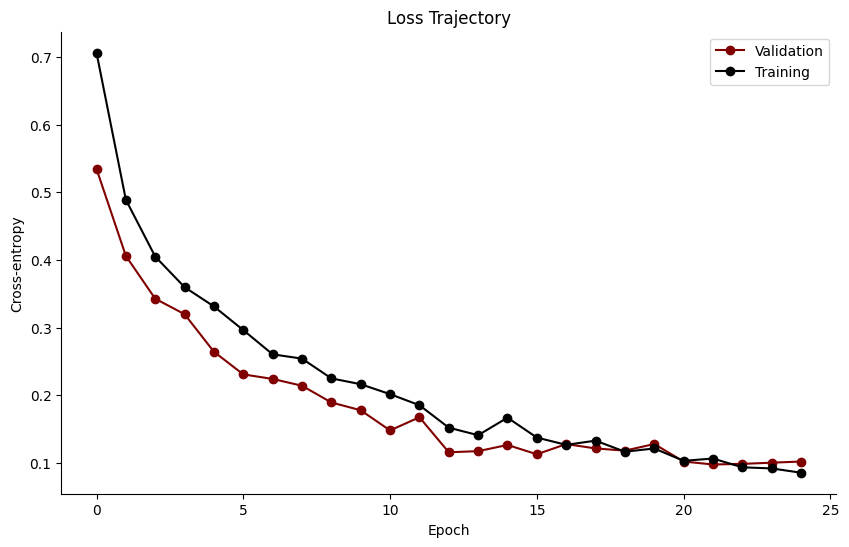

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(25), weighted_smote_model_fit.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(25), weighted_smote_model_fit.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

22/22 [==============================] - 0s 1ms/step


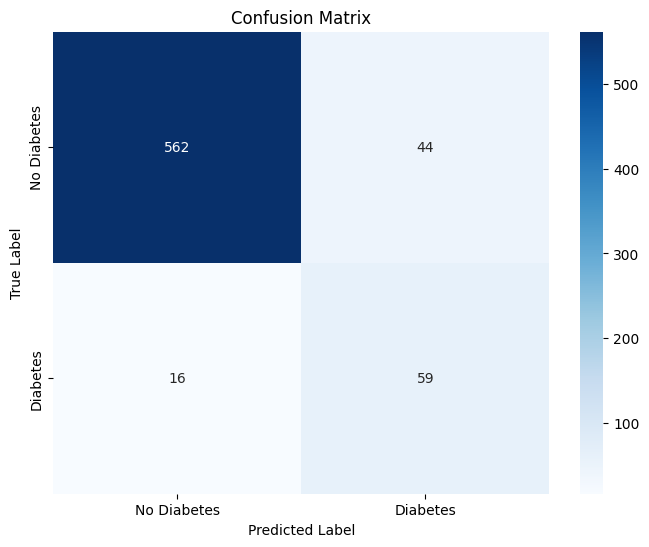

              precision    recall  f1-score   support

 No Diabetes       0.97      0.93      0.95       606
    Diabetes       0.57      0.79      0.66        75

    accuracy                           0.91       681
   macro avg       0.77      0.86      0.81       681
weighted avg       0.93      0.91      0.92       681



In [92]:
# Predict classes using the test set
y_pred = regularized_smote_model.predict(X_test_transformed)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report for precision, recall, f1-score
print(classification_report(y_test, y_pred_classes, target_names=['No Diabetes', 'Diabetes']))

## Clean the data even more
By getting rid of some of the columns of data such as income insurance information, we hope to make the model even better. 

In [212]:
cleaner_data = pd.read_csv('nhanesBetter.csv')
cleaner_data.head()

,blood_cholesterol_mg_per_dc,blood_glycosylated_hemoglobin_volume_percentage,household_ref_person_age_year,household_ref_person_biological_sex,subject_age_year_screening_time,subject_biological_sex,subject_high_blood_pressure,subject_2_year_weight_screening_time,subject_2_year_mec_weight_mec_time,subject_race_ethnicity,diagnosis
0,168,5.5,61,2,61,Female,Yes,60325.09525,61758.65488,White Hispanic,False
1,168,5.2,26,2,26,Female,No,89514.43322,91523.51605,White Hispanic,False
2,131,5.0,33,2,33,Female,No,14155.31300,15397.21985,Non-White,False
3,154,5.1,35,2,16,Male,No,12433.74874,12665.77009,White Hispanic,False
4,225,5.8,38,2,38,Female,No,27388.92069,27196.63839,White Hispanic,False


In [213]:
# Define numerical and categorical features
numerical_cols = cleaner_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = cleaner_data.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [214]:
# Create a new model using TensorFlow/Keras, more similar to your class example
def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[input_shape], bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(64, activation='relu', bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.45),
        keras.layers.Dense(32, activation='relu', bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid', bias_regularizer=regularizers.L2(1e-4))
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [215]:
# Split data into X and y
X = cleaner_data.drop('diagnosis', axis=1)
y = cleaner_data['diagnosis'].astype(int)  # for binary classification

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the preprocessor to the training data and transform it
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Further split the training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_transformed, y_train, test_size=0.2, random_state=42)

# Get the number of features from the transformed data
input_shape = X_train_transformed.shape[1]

In [216]:
# Fit the model
weight_for_0 = (1 / 600) * (681 / 2.0)
weight_for_1 = (1 / 81) * (681 / 2.0)

model = build_model(input_shape)
class_weight = {0: weight_for_0, 1: weight_for_1}
model_fit = model.fit(X_train_final, y_train_final, epochs=30, validation_data=(X_val, y_val), class_weight=class_weight)

Epoch 1/30
68/68 [==============================] - 1s 5ms/step - loss: 0.5860 - accuracy: 0.6144 - val_loss: 0.4476 - val_accuracy: 0.8125
Epoch 2/30
68/68 [==============================] - 0s 3ms/step - loss: 0.4657 - accuracy: 0.7923 - val_loss: 0.3233 - val_accuracy: 0.8971
Epoch 3/30
68/68 [==============================] - 0s 2ms/step - loss: 0.3897 - accuracy: 0.8483 - val_loss: 0.2539 - val_accuracy: 0.9191
Epoch 4/30
68/68 [==============================] - 0s 3ms/step - loss: 0.3908 - accuracy: 0.8695 - val_loss: 0.2734 - val_accuracy: 0.9136
Epoch 5/30
68/68 [==============================] - 0s 4ms/step - loss: 0.3403 - accuracy: 0.8833 - val_loss: 0.2290 - val_accuracy: 0.9265
Epoch 6/30
68/68 [==============================] - 0s 3ms/step - loss: 0.3591 - accuracy: 0.8883 - val_loss: 0.2662 - val_accuracy: 0.9154
Epoch 7/30
68/68 [==============================] - 0s 2ms/step - loss: 0.3426 - accuracy: 0.8984 - val_loss: 0.2329 - val_accuracy: 0.9210
Epoch 8/30
68/68 [==

In [217]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 128)               2048      
                                                                 
 dropout_109 (Dropout)       (None, 128)               0         
                                                                 
 dense_149 (Dense)           (None, 64)                8256      
                                                                 
 dropout_110 (Dropout)       (None, 64)                0         
                                                                 
 dense_150 (Dense)           (None, 32)                2080      
                                                                 
 dropout_111 (Dropout)       (None, 32)                0         
                                                                 
 dense_151 (Dense)           (None, 1)               

In [218]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_transformed, y_test)
print("Accuracy:", accuracy)

22/22 [==============================] - 0s 2ms/step - loss: 0.2972 - accuracy: 0.8825
Accuracy: 0.8825256824493408


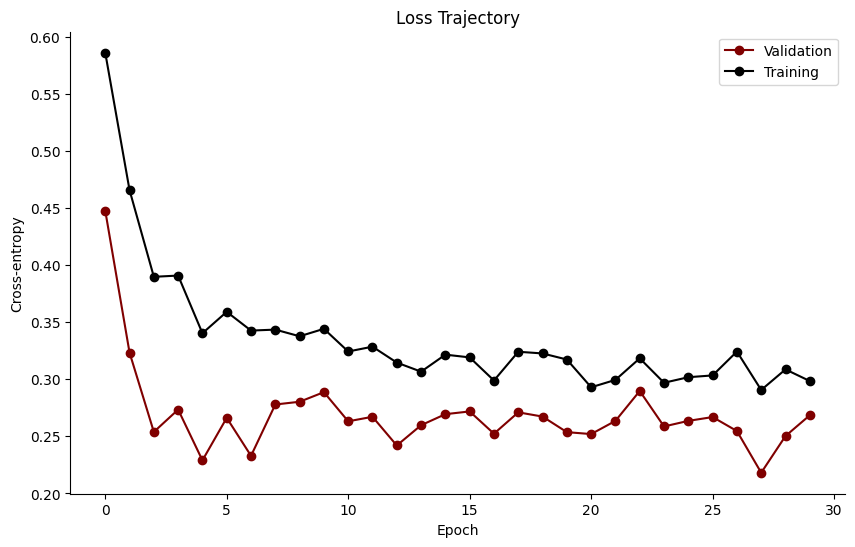

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(30), model_fit.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(30), model_fit.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

22/22 [==============================] - 0s 1ms/step


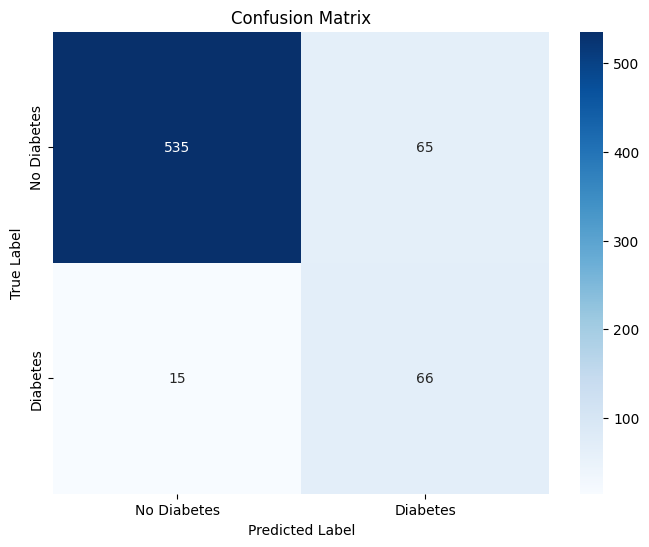

              precision    recall  f1-score   support

 No Diabetes       0.97      0.89      0.93       600
    Diabetes       0.50      0.81      0.62        81

    accuracy                           0.88       681
   macro avg       0.74      0.85      0.78       681
weighted avg       0.92      0.88      0.89       681



In [220]:
# Predict classes using the test set
y_pred = model.predict(X_test_transformed)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report for precision, recall, f1-score
print(classification_report(y_test, y_pred_classes, target_names=['No Diabetes', 'Diabetes']))

## Smote with new data
Try SMOTE with the cleaner data to see if that makes the model more accurate for Diabetes=True

In [221]:
# Split data into X and y
X = cleaner_data.drop('diagnosis', axis=1)
y = cleaner_data['diagnosis'].astype(int)

# Split original data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Bundle preprocessing for numerical and categorical data into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the preprocessor to the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE only to the preprocessed training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Split the resampled training data into final training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Get the number of features from the transformed data
input_shape = X_train_resampled.shape[1]

# Check the class distribution after applying SMOTE
print("Before SMOTE:")
print(y_train.value_counts())

print("After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Before SMOTE:
diagnosis
0    2400
1     320
Name: count, dtype: int64
After SMOTE:
diagnosis
0    2400
1    2400
Name: count, dtype: int64


/home/carrc4/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [203]:
# Create a new model using TensorFlow/Keras, more similar to your class example
def build_regularized_smote_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[input_shape], bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu', bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(32, activation='relu', bias_regularizer=regularizers.L2(1e-4)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid', bias_regularizer=regularizers.L2(1e-4))
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [208]:
# Fit the model
weight_for_0 = (1 / 606) * (681 / 2.0)
weight_for_1 = (1 / 75) * (681 / 2.0)*0.75

smote_model = build_regularized_smote_model(input_shape)
class_weight = {0: weight_for_0, 1: weight_for_1}
smote_model_fit = smote_model.fit(X_train_final, y_train_final, epochs=100, validation_data=(X_val, y_val), class_weight=class_weight)

Epoch 1/100
120/120 [==============================] - 2s 4ms/step - loss: 0.6331 - accuracy: 0.5818 - val_loss: 0.5260 - val_accuracy: 0.7552
Epoch 2/100
120/120 [==============================] - 0s 2ms/step - loss: 0.4503 - accuracy: 0.7594 - val_loss: 0.3766 - val_accuracy: 0.8615
Epoch 3/100
120/120 [==============================] - 0s 2ms/step - loss: 0.4237 - accuracy: 0.7849 - val_loss: 0.3828 - val_accuracy: 0.8479
Epoch 4/100
120/120 [==============================] - 0s 2ms/step - loss: 0.4012 - accuracy: 0.8102 - val_loss: 0.3595 - val_accuracy: 0.8719
Epoch 5/100
120/120 [==============================] - 0s 3ms/step - loss: 0.3858 - accuracy: 0.8086 - val_loss: 0.3508 - val_accuracy: 0.8708
Epoch 6/100
120/120 [==============================] - 0s 2ms/step - loss: 0.3818 - accuracy: 0.8203 - val_loss: 0.3497 - val_accuracy: 0.8740
Epoch 7/100
120/120 [==============================] - 0s 2ms/step - loss: 0.3756 - accuracy: 0.8289 - val_loss: 0.3330 - val_accuracy: 0.8729

In [209]:
# Evaluate the model on the test data
loss, accuracy = smote_model.evaluate(X_test_transformed, y_test)
print("Accuracy:", accuracy)

22/22 [==============================] - 0s 2ms/step - loss: 0.4906 - accuracy: 0.8590
Accuracy: 0.8590308427810669


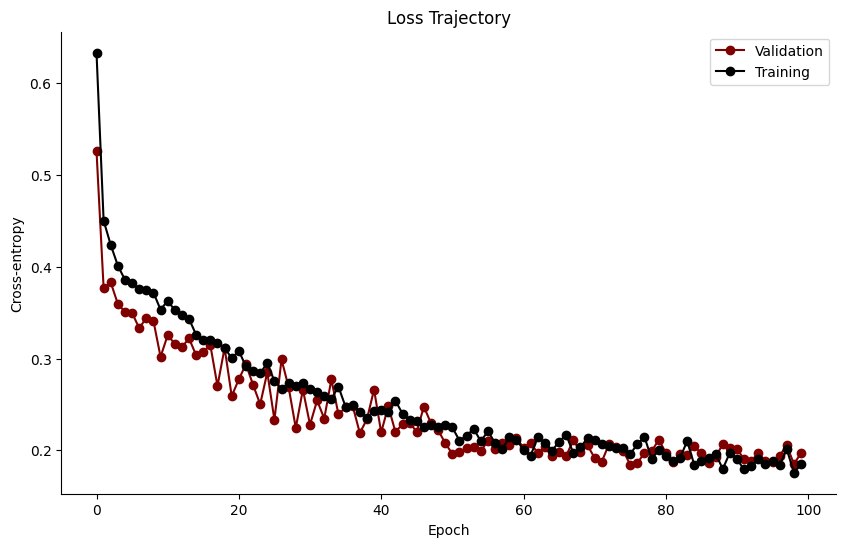

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(100), smote_model_fit.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(100), smote_model_fit.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

22/22 [==============================] - 0s 1ms/step


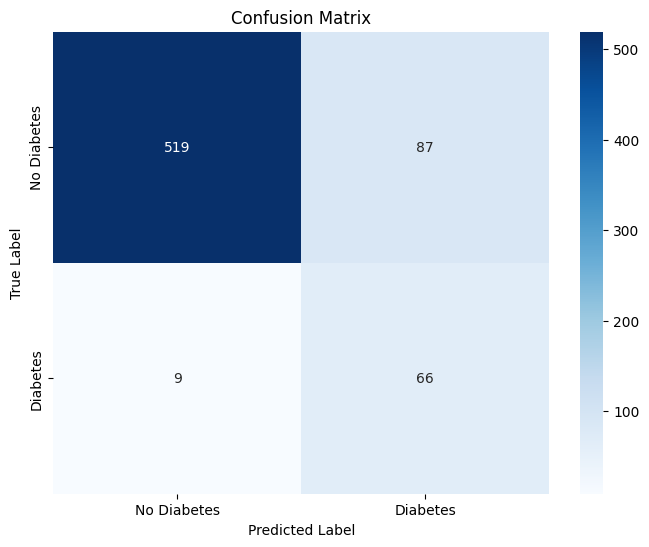

              precision    recall  f1-score   support

 No Diabetes       0.98      0.86      0.92       606
    Diabetes       0.43      0.88      0.58        75

    accuracy                           0.86       681
   macro avg       0.71      0.87      0.75       681
weighted avg       0.92      0.86      0.88       681



In [211]:
# Predict classes using the test set
y_pred = smote_model.predict(X_test_transformed)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print classification report for precision, recall, f1-score
print(classification_report(y_test, y_pred_classes, target_names=['No Diabetes', 'Diabetes']))